In [2]:
import numpy as np
import sys
import time
import h5py
from tqdm import tqdm

import numpy as np
import re
from math import ceil
from sklearn.metrics import average_precision_score
from torch.utils.data import Dataset
import torch
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
import pickle
#import pickle5 as pickle

from sklearn.model_selection import train_test_split

from scipy.sparse import load_npz
from glob import glob

from transformers import get_constant_schedule_with_warmup
from sklearn.metrics import precision_score,recall_score,accuracy_score
import copy

from src.train import trainModel

#from src.dataloader import getData,spliceDataset,h5pyDataset,collate_fn
from src.dataloader import get_GTEX_v8_Data,spliceDataset,h5pyDataset,getDataPointList,getDataPointListGTEX,DataPointGTEX
from src.weight_init import keras_init
from src.losses import categorical_crossentropy_2d,kl_div_2d
from src.model import SpliceFormer
from src.evaluation_metrics import print_topl_statistics,cross_entropy_2d

In [3]:
!nvidia-smi

Mon May 22 16:26:24 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.43.04    Driver Version: 515.43.04    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-PCI...  Off  | 00000000:31:00.0 Off |                    0 |
| N/A   37C    P0    37W / 250W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A100-PCI...  Off  | 00000000:98:00.0 Off |                    0 |
| N/A   

In [4]:
#!pip install pickle5

In [5]:
rng = np.random.default_rng(23673)

In [6]:
#gtf = None

In [7]:
L = 32
N_GPUS = 3
k = 2
NUM_ACCUMULATION_STEPS=1
# Hyper-parameters:
# L: Number of convolution kernels
# W: Convolution window size in each residual unit
# AR: Atrous rate in each residual unit

W = np.asarray([11, 11, 11, 11, 11, 11, 11, 11,
                21, 21, 21, 21, 41, 41, 41, 41])
AR = np.asarray([1, 1, 1, 1, 4, 4, 4, 4,
                 10, 10, 10, 10, 25, 25, 25, 25])
BATCH_SIZE = 16*k*N_GPUS

k = NUM_ACCUMULATION_STEPS*k

CL = 2 * np.sum(AR*(W-1))

In [8]:
data_dir = '/odinn/tmp/benediktj/Data/SplicePrediction-GTEX-V8'
setType = 'train'
annotation, gene_to_label, seqData = get_GTEX_v8_Data(data_dir, setType,'annotation_GTEX_v8.txt')

In [9]:
# Maximum nucleotide context length (CL_max/2 on either side of the 
# position of interest)
# CL_max should be an even number
# Sequence length of SpliceAIs (SL+CL will be the input length and
# SL will be the output length)

SL=5000
CL_max=40000

In [10]:
assert CL_max % 2 == 0

In [11]:
train_gene, validation_gene = train_test_split(annotation['gene'].drop_duplicates(),test_size=.1,random_state=435)
annotation_train = annotation[annotation['gene'].isin(train_gene)]
annotation_validation = annotation[annotation['gene'].isin(validation_gene)]

In [ ]:
#with open('{}/sparse_discrete_gene_label_data_{}.pickle'.format(data_dir,setType), 'rb') as handle:
#    gene_to_label_old = pickle.load(handle)

In [ ]:
#for gene in gene_to_label_old.keys():
#    if len(gene_to_label[gene])==0:
#        gene_to_label[gene] = gene_to_label_old[gene]

In [12]:
train_dataset = spliceDataset(getDataPointListGTEX(annotation_train,gene_to_label,SL,CL_max,shift=SL))
val_dataset = spliceDataset(getDataPointListGTEX(annotation_validation,gene_to_label,SL,CL_max,shift=SL))
train_dataset.seqData = seqData
val_dataset.seqData = seqData

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=16, pin_memory=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE//4, shuffle=False, num_workers=16)

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
epochs = 4
hs = []
learning_rate= k*1e-4
gamma=0.5
temp = 1
#final_lr = 1e-5
#gamma = 1/(learning_rate/final_lr)**(1/5) 

Epoch (train) 1/4: 100%|██████████████████████████████████████████████████████████████████████████████| 1425/1425 [29:19<00:00,  1.23s/it, a_r=0.641, d_r=0.637, loss=0.000791, r_a=0.994, r_d=0.993, r_loss=6.05]


epoch: 1/4, train loss = 0.000857


Epoch (val) 1/4: 100%|███████████████████████████████████████████████████████████████████████████████████| 612/612 [06:00<00:00,  1.70it/s, a_r=0.623, d_r=0.606, loss=0.00107, r_a=0.994, r_d=0.993, r_loss=7.97]



Acceptor:
0.9979	0.7459	0.8673	0.942	0.8333	0.9846	0.2584	0.0785	0.0200	14681	19682.0	19682

Donor:
0.9974	0.7453	0.8705	0.9426	0.8323	0.9815	0.2320	0.0690	0.0172	14990	20114.0	20114
epoch: 1/4, val loss = 0.000799


Epoch (train) 2/4: 100%|██████████████████████████████████████████████████████████████████████████████| 1425/1425 [28:54<00:00,  1.22s/it, a_r=0.646, d_r=0.645, loss=0.000755, r_a=0.994, r_d=0.994, r_loss=5.78]


epoch: 2/4, train loss = 0.000769


Epoch (val) 2/4: 100%|███████████████████████████████████████████████████████████████████████████████████| 612/612 [05:48<00:00,  1.75it/s, a_r=0.619, d_r=0.613, loss=0.00105, r_a=0.994, r_d=0.994, r_loss=7.83]



Acceptor:
0.9983	0.7494	0.8737	0.9476	0.8386	0.9863	0.2622	0.0805	0.0197	14750	19682.0	19682

Donor:
0.9979	0.7473	0.8748	0.9461	0.8364	0.9858	0.2544	0.0732	0.0172	15031	20114.0	20114
epoch: 2/4, val loss = 0.000782


Epoch (train) 3/4: 100%|██████████████████████████████████████████████████████████████████████████████| 1425/1425 [28:38<00:00,  1.21s/it, a_r=0.652, d_r=0.648, loss=0.000747, r_a=0.995, r_d=0.994, r_loss=5.81]


epoch: 3/4, train loss = 0.000746


Epoch (val) 3/4: 100%|███████████████████████████████████████████████████████████████████████████████████| 612/612 [05:55<00:00,  1.72it/s, a_r=0.613, d_r=0.609, loss=0.00104, r_a=0.995, r_d=0.994, r_loss=7.85]



Acceptor:
0.9985	0.7512	0.8755	0.95	0.8408	0.9846	0.2287	0.0683	0.0171	14785	19682.0	19682

Donor:
0.9973	0.7497	0.8753	0.9477	0.8378	0.9832	0.2321	0.0642	0.0157	15079	20114.0	20114
epoch: 3/4, val loss = 0.000773


Epoch (train) 4/4: 100%|███████████████████████████████████████████████████████████████████████████████| 1425/1425 [28:39<00:00,  1.21s/it, a_r=0.655, d_r=0.657, loss=0.000721, r_a=0.995, r_d=0.995, r_loss=5.7]


epoch: 4/4, train loss = 0.000729


Epoch (val) 4/4: 100%|███████████████████████████████████████████████████████████████████████████████████| 612/612 [06:05<00:00,  1.67it/s, a_r=0.619, d_r=0.609, loss=0.00103, r_a=0.995, r_d=0.995, r_loss=7.68]



Acceptor:
0.9985	0.7535	0.8778	0.9505	0.8414	0.9877	0.2573	0.0761	0.0174	14831	19682.0	19682

Donor:
0.9977	0.7498	0.8772	0.9492	0.8391	0.9873	0.2470	0.0741	0.0189	15082	20114.0	20114
epoch: 4/4, val loss = 0.000770


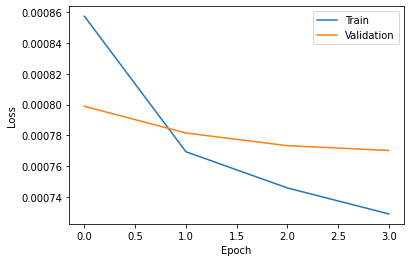

Epoch (train) 1/4: 100%|████████████████████████████████████████████████████████████████████████████████| 1425/1425 [28:51<00:00,  1.22s/it, a_r=0.641, d_r=0.64, loss=0.00079, r_a=0.993, r_d=0.993, r_loss=5.22]


epoch: 1/4, train loss = 0.000863


Epoch (train) 2/4: 100%|██████████████████████████████████████████████████████████████████████████████| 1425/1425 [28:41<00:00,  1.21s/it, a_r=0.647, d_r=0.644, loss=0.000771, r_a=0.994, r_d=0.993, r_loss=5.21]


epoch: 2/4, train loss = 0.000771


Epoch (train) 3/4: 100%|██████████████████████████████████████████████████████████████████████████████| 1425/1425 [29:11<00:00,  1.23s/it, a_r=0.651, d_r=0.646, loss=0.000738, r_a=0.994, r_d=0.995, r_loss=5.13]


epoch: 3/4, train loss = 0.000747


Epoch (train) 4/4: 100%|██████████████████████████████████████████████████████████████████████████████| 1425/1425 [28:54<00:00,  1.22s/it, a_r=0.655, d_r=0.653, loss=0.000724, r_a=0.995, r_d=0.995, r_loss=5.22]


epoch: 4/4, train loss = 0.000730


Epoch (train) 1/4: 100%|██████████████████████████████████████████████████████████████████████████████| 1425/1425 [28:39<00:00,  1.21s/it, a_r=0.642, d_r=0.641, loss=0.000791, r_a=0.994, r_d=0.993, r_loss=5.32]


epoch: 1/4, train loss = 0.000859


Epoch (train) 2/4: 100%|██████████████████████████████████████████████████████████████████████████████| 1425/1425 [28:57<00:00,  1.22s/it, a_r=0.641, d_r=0.645, loss=0.000774, r_a=0.994, r_d=0.994, r_loss=5.32]


epoch: 2/4, train loss = 0.000768


Epoch (train) 3/4: 100%|██████████████████████████████████████████████████████████████████████████████| 1425/1425 [28:55<00:00,  1.22s/it, a_r=0.658, d_r=0.661, loss=0.000729, r_a=0.994, r_d=0.994, r_loss=5.25]


epoch: 3/4, train loss = 0.000746


Epoch (train) 4/4: 100%|██████████████████████████████████████████████████████████████████████████████| 1425/1425 [29:07<00:00,  1.23s/it, a_r=0.658, d_r=0.651, loss=0.000741, r_a=0.995, r_d=0.995, r_loss=5.28]


epoch: 4/4, train loss = 0.000729


Epoch (train) 1/4: 100%|██████████████████████████████████████████████████████████████████████████████| 1425/1425 [29:15<00:00,  1.23s/it, a_r=0.641, d_r=0.644, loss=0.000811, r_a=0.988, r_d=0.991, r_loss=3.12]


epoch: 1/4, train loss = 0.000852


Epoch (train) 2/4: 100%|██████████████████████████████████████████████████████████████████████████████| 1425/1425 [28:48<00:00,  1.21s/it, a_r=0.648, d_r=0.644, loss=0.000756, r_a=0.989, r_d=0.992, r_loss=2.85]


epoch: 2/4, train loss = 0.000769


Epoch (train) 3/4: 100%|██████████████████████████████████████████████████████████████████████████████| 1425/1425 [28:58<00:00,  1.22s/it, a_r=0.647, d_r=0.645, loss=0.000754, r_a=0.992, r_d=0.993, r_loss=2.81]


epoch: 3/4, train loss = 0.000747


Epoch (train) 4/4: 100%|███████████████████████████████████████████████████████████████████████████████| 1425/1425 [28:47<00:00,  1.21s/it, a_r=0.653, d_r=0.65, loss=0.000731, r_a=0.991, r_d=0.993, r_loss=2.88]


epoch: 4/4, train loss = 0.000731


Epoch (train) 1/4: 100%|██████████████████████████████████████████████████████████████████████████████| 1425/1425 [29:02<00:00,  1.22s/it, a_r=0.643, d_r=0.638, loss=0.000783, r_a=0.994, r_d=0.993, r_loss=4.93]


epoch: 1/4, train loss = 0.000857


Epoch (train) 2/4: 100%|███████████████████████████████████████████████████████████████████████████████| 1425/1425 [28:59<00:00,  1.22s/it, a_r=0.641, d_r=0.64, loss=0.000773, r_a=0.994, r_d=0.994, r_loss=4.75]


epoch: 2/4, train loss = 0.000769


Epoch (train) 3/4: 100%|███████████████████████████████████████████████████████████████████████████████| 1425/1425 [28:51<00:00,  1.22s/it, a_r=0.652, d_r=0.649, loss=0.000739, r_a=0.994, r_d=0.994, r_loss=4.7]


epoch: 3/4, train loss = 0.000748


Epoch (train) 4/4: 100%|██████████████████████████████████████████████████████████████████████████████| 1425/1425 [28:57<00:00,  1.22s/it, a_r=0.653, d_r=0.647, loss=0.000751, r_a=0.995, r_d=0.994, r_loss=4.87]


epoch: 4/4, train loss = 0.000731


Epoch (train) 1/4: 100%|██████████████████████████████████████████████████████████████████████████████| 1425/1425 [28:43<00:00,  1.21s/it, a_r=0.641, d_r=0.638, loss=0.000782, r_a=0.994, r_d=0.994, r_loss=8.74]


epoch: 1/4, train loss = 0.000854


Epoch (train) 2/4: 100%|██████████████████████████████████████████████████████████████████████████████| 1425/1425 [28:57<00:00,  1.22s/it, a_r=0.653, d_r=0.648, loss=0.000753, r_a=0.995, r_d=0.995, r_loss=8.69]


epoch: 2/4, train loss = 0.000772


Epoch (train) 3/4: 100%|██████████████████████████████████████████████████████████████████████████████| 1425/1425 [28:49<00:00,  1.21s/it, a_r=0.662, d_r=0.657, loss=0.000753, r_a=0.994, r_d=0.994, r_loss=8.76]


epoch: 3/4, train loss = 0.000750


Epoch (train) 4/4: 100%|███████████████████████████████████████████████████████████████████████████████| 1425/1425 [28:49<00:00,  1.21s/it, a_r=0.655, d_r=0.65, loss=0.000734, r_a=0.995, r_d=0.995, r_loss=8.48]


epoch: 4/4, train loss = 0.000733


Epoch (train) 1/4: 100%|████████████████████████████████████████████████████████████████████████████████| 1425/1425 [28:53<00:00,  1.22s/it, a_r=0.643, d_r=0.64, loss=0.000776, r_a=0.994, r_d=0.994, r_loss=8.7]


epoch: 1/4, train loss = 0.000852


Epoch (train) 2/4: 100%|██████████████████████████████████████████████████████████████████████████████| 1425/1425 [28:56<00:00,  1.22s/it, a_r=0.649, d_r=0.645, loss=0.000762, r_a=0.994, r_d=0.994, r_loss=8.74]


epoch: 2/4, train loss = 0.000770


Epoch (train) 3/4: 100%|███████████████████████████████████████████████████████████████████████████████| 1425/1425 [28:56<00:00,  1.22s/it, a_r=0.652, d_r=0.641, loss=0.000743, r_a=0.995, r_d=0.995, r_loss=8.4]


epoch: 3/4, train loss = 0.000748


Epoch (train) 4/4: 100%|███████████████████████████████████████████████████████████████████████████████| 1425/1425 [28:43<00:00,  1.21s/it, a_r=0.658, d_r=0.651, loss=0.000745, r_a=0.996, r_d=0.995, r_loss=8.4]


epoch: 4/4, train loss = 0.000731


Epoch (train) 1/4: 100%|██████████████████████████████████████████████████████████████████████████████| 1425/1425 [28:38<00:00,  1.21s/it, a_r=0.641, d_r=0.637, loss=0.000786, r_a=0.993, r_d=0.992, r_loss=8.46]


epoch: 1/4, train loss = 0.000849


Epoch (train) 2/4: 100%|██████████████████████████████████████████████████████████████████████████████| 1425/1425 [28:44<00:00,  1.21s/it, a_r=0.641, d_r=0.645, loss=0.000764, r_a=0.995, r_d=0.994, r_loss=8.28]


epoch: 2/4, train loss = 0.000771


Epoch (train) 3/4: 100%|███████████████████████████████████████████████████████████████████████████████| 1425/1425 [28:50<00:00,  1.21s/it, a_r=0.642, d_r=0.642, loss=0.000748, r_a=0.995, r_d=0.995, r_loss=8.1]


epoch: 3/4, train loss = 0.000747


Epoch (train) 4/4: 100%|██████████████████████████████████████████████████████████████████████████████| 1425/1425 [28:49<00:00,  1.21s/it, a_r=0.655, d_r=0.655, loss=0.000725, r_a=0.995, r_d=0.994, r_loss=7.87]


epoch: 4/4, train loss = 0.000731


Epoch (train) 1/4: 100%|███████████████████████████████████████████████████████████████████████████████| 1425/1425 [28:54<00:00,  1.22s/it, a_r=0.642, d_r=0.636, loss=0.00079, r_a=0.994, r_d=0.993, r_loss=8.89]


epoch: 1/4, train loss = 0.000855


Epoch (train) 2/4: 100%|██████████████████████████████████████████████████████████████████████████████| 1425/1425 [28:49<00:00,  1.21s/it, a_r=0.649, d_r=0.647, loss=0.000765, r_a=0.995, r_d=0.995, r_loss=8.78]


epoch: 2/4, train loss = 0.000772


Epoch (train) 3/4: 100%|██████████████████████████████████████████████████████████████████████████████| 1425/1425 [29:00<00:00,  1.22s/it, a_r=0.652, d_r=0.654, loss=0.000737, r_a=0.994, r_d=0.995, r_loss=8.57]


epoch: 3/4, train loss = 0.000749


Epoch (train) 4/4: 100%|██████████████████████████████████████████████████████████████████████████████| 1425/1425 [28:52<00:00,  1.22s/it, a_r=0.655, d_r=0.651, loss=0.000738, r_a=0.994, r_d=0.995, r_loss=8.73]


epoch: 4/4, train loss = 0.000733


Epoch (train) 1/4: 100%|█████████████████████████████████████████████████████████████████████████████████| 1425/1425 [28:59<00:00,  1.22s/it, a_r=0.65, d_r=0.646, loss=0.0008, r_a=0.994, r_d=0.992, r_loss=8.47]


epoch: 1/4, train loss = 0.000860


Epoch (train) 2/4: 100%|███████████████████████████████████████████████████████████████████████████████| 1425/1425 [28:54<00:00,  1.22s/it, a_r=0.64, d_r=0.642, loss=0.000786, r_a=0.994, r_d=0.993, r_loss=8.08]


epoch: 2/4, train loss = 0.000774


Epoch (train) 3/4: 100%|██████████████████████████████████████████████████████████████████████████████| 1425/1425 [28:51<00:00,  1.22s/it, a_r=0.656, d_r=0.651, loss=0.000741, r_a=0.996, r_d=0.994, r_loss=8.08]


epoch: 3/4, train loss = 0.000751


Epoch (train) 4/4: 100%|██████████████████████████████████████████████████████████████████████████████| 1425/1425 [29:20<00:00,  1.24s/it, a_r=0.655, d_r=0.645, loss=0.000726, r_a=0.996, r_d=0.995, r_loss=7.95]

epoch: 4/4, train loss = 0.000735


In [15]:
for model_nr in range(10):
    model_m = SpliceFormer(CL_max,bn_momentum=0.01/NUM_ACCUMULATION_STEPS,depth=4,heads=4,n_transformer_blocks=2)
    model_m.apply(keras_init)
    model_m = model_m.to(device)
    if torch.cuda.device_count() > 1:
        #print("Let's use", torch.cuda.device_count(), "GPUs!")
        # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
        model_m = nn.DataParallel(model_m)
    
    model_m.load_state_dict(torch.load('../Results/PyTorch_Models/transformer_encoder_40k_171022_{}'.format(model_nr)))
    modelFileName = '../Results/PyTorch_Models/transformer_encoder_40k_finetune_GTEX_021222_{}'.format(model_nr)
    loss = categorical_crossentropy_2d().loss
    #loss = kl_div_2d(temp=temp).loss
    optimizer = torch.optim.AdamW(model_m.parameters(), lr=learning_rate, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=gamma)
    warmup = get_constant_schedule_with_warmup(optimizer, num_warmup_steps=100)
    if model_nr>0:
        h = trainModel(model_m,modelFileName,loss,train_loader,val_loader,optimizer,scheduler,warmup,BATCH_SIZE,epochs,device,skipValidation=True,lowValidationGPUMem=True,NUM_ACCUMULATION_STEPS=NUM_ACCUMULATION_STEPS,CL_max=CL_max,reinforce=True,continous_labels=False)
    else:
        h = trainModel(model_m,modelFileName,loss,train_loader,val_loader,optimizer,scheduler,warmup,BATCH_SIZE,epochs,device,skipValidation=False,lowValidationGPUMem=True,NUM_ACCUMULATION_STEPS=NUM_ACCUMULATION_STEPS,CL_max=CL_max,reinforce=True,continous_labels=False)
        plt.plot(range(epochs),h['loss'],label='Train')
        plt.plot(range(epochs),h['val_loss'],label='Validation')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()
    hs.append(h)

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
h5f = h5py.File('/odinn/tmp/benediktj/Data/SplicePrediction/gencode_40k_dataset_test_.h5')

num_idx = len(h5f.keys())//2

test_dataset = h5pyDataset(h5f,list(range(num_idx)))
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=0)

temp = 1
n_models = 5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_m = SpliceFormer(CL_max,bn_momentum=0.01/NUM_ACCUMULATION_STEPS,depth=4,heads=4,n_transformer_blocks=2,determenistic=True)
model_m.apply(keras_init)
model_m = model_m.to(device)

if torch.cuda.device_count() > 1:
    model_m = nn.DataParallel(model_m)

output_class_labels = ['Null', 'Acceptor', 'Donor']

#for output_class in [1,2]:
models = [copy.deepcopy(model_m) for i in range(n_models)]
[model.load_state_dict(torch.load('../Results/PyTorch_Models/transformer_encoder_40k_finetune_GTEX_021222_{}'.format(i))) for i,model in enumerate(models)]

for model in models:
    model.eval()
    
Y_true_acceptor, Y_pred_acceptor = [],[]
Y_true_donor, Y_pred_donor = [],[]
ce_2d = []

for (batch_chunks,target_chunks) in tqdm(test_loader):
    batch_chunks = torch.transpose(batch_chunks[0].to(device),1,2)
    target_chunks = torch.transpose(torch.squeeze(target_chunks[0].to(device),0),1,2)
    #print(np.max(target_chunks.cpu().numpy()[:,2,:]))
    n_chunks = int(np.ceil(batch_chunks.shape[0]/BATCH_SIZE))
    batch_chunks = torch.chunk(batch_chunks, n_chunks, dim=0)
    target_chunks = torch.chunk(target_chunks, n_chunks, dim=0)
    targets_list = []
    outputs_list = []
    for j in range(len(batch_chunks)):
        batch_features = batch_chunks[j]
        targets = target_chunks[j]
        outputs = ([models[i](batch_features)[0].detach() for i in range(n_models)])
        #outputs = (outputs[0]+outputs[1]+outputs[2]+outputs[3]+outputs[4])/n_models
        outputs = torch.mean(torch.stack(outputs),dim=0)
        #outputs = odds_gmean(torch.stack(outputs))
        #outputs = (outputs[0]+outputs[1]+outputs[2])/n_models
        targets_list.extend(targets.unsqueeze(0))
        outputs_list.extend(outputs.unsqueeze(0))

    targets = torch.transpose(torch.vstack(targets_list),1,2).cpu().numpy()
    outputs = torch.transpose(torch.vstack(outputs_list),1,2).cpu().numpy()
    ce_2d.append(cross_entropy_2d(targets,outputs))

    is_expr = (targets.sum(axis=(1,2)) >= 1)
    Y_true_acceptor.extend(targets[is_expr, :, 1].flatten())
    Y_true_donor.extend(targets[is_expr, :, 2].flatten())
    Y_pred_acceptor.extend(outputs[is_expr, :, 1].flatten())
    Y_pred_donor.extend(outputs[is_expr, :, 2].flatten())

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [02:59<00:00, 10.59s/it]


In [18]:
mean_ce = np.mean(ce_2d)
print('Cross entropy = {}'.format(mean_ce))
Y_true_acceptor, Y_pred_acceptor,Y_true_donor, Y_pred_donor = np.array(Y_true_acceptor), np.array(Y_pred_acceptor),np.array(Y_true_donor), np.array(Y_pred_donor)
print("\n\033[1m{}:\033[0m".format('Acceptor'))
acceptor_val_results = print_topl_statistics(Y_true_acceptor, Y_pred_acceptor)
print("\n\033[1m{}:\033[0m".format('Donor'))
donor_val_results =print_topl_statistics(Y_true_donor, Y_pred_donor)

Cross entropy = 0.000540425745996493

Acceptor:
0.9964	0.9345	0.9845	0.9883	0.9714	0.9966	0.7516	0.1659	0.0455	13353	14289.0	14289

Donor:
0.9962	0.9381	0.9868	0.9912	0.9747	0.9968	0.7797	0.1718	0.0460	13405	14289.0	14289


In [19]:
from src.dataloader import getData
setType = 'test'
annotation_test, transcriptToLabel_test, seqData = getData('/odinn/tmp/benediktj/Data/SplicePrediction-050422', setType)    
from src.dataloader import getDataPointListFull,DataPointFull

In [20]:
temp = 1
n_models = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_m = SpliceFormer(CL_max,bn_momentum=0.01/NUM_ACCUMULATION_STEPS,depth=4,heads=4,n_transformer_blocks=2,determenistic=True)
model_m.apply(keras_init)
model_m = model_m.to(device)

if torch.cuda.device_count() > 1:
    model_m = nn.DataParallel(model_m)

output_class_labels = ['Null', 'Acceptor', 'Donor']

#for output_class in [1,2]:
models = [copy.deepcopy(model_m) for i in range(n_models)]
[model.load_state_dict(torch.load('../Results/PyTorch_Models/transformer_encoder_40k_finetune_GTEX_021222_{}'.format(i))) for i,model in enumerate(models)]
#nr = [0,2,3]
#[model.load_state_dict(torch.load('../Results/PyTorch_Models/transformer_encoder_40k_201221_{}'.format(nr[i]))) for i,model in enumerate(models)]
#chunkSize = num_idx/10
for model in models:
    model.eval()

Y_true_acceptor, Y_pred_acceptor = [],[]
Y_true_donor, Y_pred_donor = [],[]
test_dataset = spliceDataset(getDataPointListFull(annotation_test,transcriptToLabel_test,SL,CL_max,shift=SL))
test_dataset.seqData = seqData
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)


#targets_list = []
#outputs_list = []
ce_2d = []
for (batch_features ,targets) in tqdm(test_loader):
    batch_features = batch_features.type(torch.FloatTensor).to(device)
    targets = targets.to(device)[:,:,CL_max//2:-CL_max//2]
    outputs = ([models[i](batch_features)[0].detach() for i in range(n_models)])
    #outputs = (outputs[0]+outputs[1]+outputs[2]+outputs[3]+outputs[4])/n_models
    outputs = torch.stack(outputs)
    outputs = torch.mean(outputs,dim=0)
    #outputs = odds_gmean(outputs)
    #targets_list.extend(targets.unsqueeze(0))
    #outputs_list.extend(outputs.unsqueeze(0))

    targets = torch.transpose(targets,1,2).cpu().numpy()
    outputs = torch.transpose(outputs,1,2).cpu().numpy()
    ce_2d.append(cross_entropy_2d(targets,outputs))

    is_expr = (targets.sum(axis=(1,2)) >= 1)
    Y_true_acceptor.extend(targets[is_expr, :, 1].flatten())
    Y_true_donor.extend(targets[is_expr, :, 2].flatten())
    Y_pred_acceptor.extend(outputs[is_expr, :, 1].flatten())
    Y_pred_donor.extend(outputs[is_expr, :, 2].flatten())


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1386/1386 [1:36:13<00:00,  4.17s/it]


In [21]:
mean_ce = np.mean(ce_2d)
print('Cross entropy = {}'.format(mean_ce))
Y_true_acceptor, Y_pred_acceptor,Y_true_donor, Y_pred_donor = np.array(Y_true_acceptor), np.array(Y_pred_acceptor),np.array(Y_true_donor), np.array(Y_pred_donor)
print("\n\033[1m{}:\033[0m".format('Acceptor'))
acceptor_val_results = print_topl_statistics(Y_true_acceptor, Y_pred_acceptor)
print("\n\033[1m{}:\033[0m".format('Donor'))
donor_val_results =print_topl_statistics(Y_true_donor, Y_pred_donor)

Cross entropy = 0.0003161097466255434

Acceptor:
0.9811	0.9308	0.9896	0.995	0.9621	0.9970	0.8110	0.1762	0.0538	83504	89712.0	89712

Donor:
0.9819	0.935	0.9927	0.9966	0.9661	0.9974	0.8420	0.1865	0.0557	83882	89712.0	89712


In [10]:
setType = 'test'
annotation_test, gene_to_label, seqData = get_GTEX_v8_Data(data_dir, setType,'annotation_GTEX_v8.txt')

In [11]:
temp = 1
n_models = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_m = SpliceFormer(CL_max,bn_momentum=0.01/NUM_ACCUMULATION_STEPS,depth=4,heads=4,n_transformer_blocks=2,determenistic=True)
model_m.apply(keras_init)
model_m = model_m.to(device)

if torch.cuda.device_count() > 1:
    model_m = nn.DataParallel(model_m)

output_class_labels = ['Null', 'Acceptor', 'Donor']

#for output_class in [1,2]:
models = [copy.deepcopy(model_m) for i in range(n_models)]
[model.load_state_dict(torch.load('../Results/PyTorch_Models/transformer_encoder_40k_finetune_GTEX_021222_{}'.format(i))) for i,model in enumerate(models)]
#nr = [0,2,3]
#[model.load_state_dict(torch.load('../Results/PyTorch_Models/transformer_encoder_40k_201221_{}'.format(nr[i]))) for i,model in enumerate(models)]
#chunkSize = num_idx/10
for model in models:
    model.eval()

Y_true_acceptor, Y_pred_acceptor = [],[]
Y_true_donor, Y_pred_donor = [],[]
test_dataset = spliceDataset(getDataPointListGTEX(annotation_test,gene_to_label,SL,CL_max,shift=SL))
test_dataset.seqData = seqData
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)

ce_2d = []
for (batch_features ,targets) in tqdm(test_loader):
    batch_features = batch_features.type(torch.FloatTensor).to(device)
    targets = targets.to(device)[:,:,CL_max//2:-CL_max//2]
    outputs = ([models[i](batch_features)[0].detach() for i in range(n_models)])
    outputs = torch.stack(outputs)
    outputs = torch.mean(outputs,dim=0)

    targets = torch.transpose(targets,1,2).cpu().numpy()
    outputs = torch.transpose(outputs,1,2).cpu().numpy()
    ce_2d.append(cross_entropy_2d(targets,outputs))

    is_expr = (targets.sum(axis=(1,2)) >= 1)
    Y_true_acceptor.extend(targets[is_expr, :, 1].flatten())
    Y_true_donor.extend(targets[is_expr, :, 2].flatten())
    Y_pred_acceptor.extend(outputs[is_expr, :, 1].flatten())
    Y_pred_donor.extend(outputs[is_expr, :, 2].flatten())


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 774/774 [51:58<00:00,  4.03s/it]


In [12]:
mean_ce = np.mean(ce_2d)
print('Cross entropy = {}'.format(mean_ce))
Y_true_acceptor, Y_pred_acceptor,Y_true_donor, Y_pred_donor = np.array(Y_true_acceptor), np.array(Y_pred_acceptor),np.array(Y_true_donor), np.array(Y_pred_donor)
print("\n\033[1m{}:\033[0m".format('Acceptor'))
acceptor_val_results = print_topl_statistics(Y_true_acceptor>0, Y_pred_acceptor)
print("\n\033[1m{}:\033[0m".format('Donor'))
donor_val_results =print_topl_statistics(Y_true_donor>0, Y_pred_donor)

Cross entropy = 0.0006119976054213493

Acceptor:
0.9977	0.7589	0.8938	0.9618	0.8516	0.9632	0.2236	0.0684	0.0175	67994	89600.0	89600

Donor:
0.9978	0.7576	0.888	0.956	0.847	0.9662	0.2287	0.0679	0.0178	69145	91272.0	91272


In [13]:
df = pd.DataFrame({'Y_true_acceptor':Y_true_acceptor,'Y_pred_acceptor':Y_pred_acceptor,'Y_true_donor':Y_true_donor,'Y_pred_donor':Y_pred_donor})
df.to_csv('/odinn/tmp/benediktj/Data/SplicePrediction-GTEX-V8/transformer_40k_test_set_predictions_120123.gz',index=False)

In [1]:
(0.8516+0.847)/2

0.8492999999999999

In [2]:
(0.7589+0.7576)/2

0.7582500000000001

In [3]:
67994+69145

137139

In [4]:
89600+91272

180872

In [15]:
setType = 'test'
annotation_test, gene_to_label, seqData = get_GTEX_v8_Data('/odinn/tmp/benediktj/Data/SplicePrediction-rnasplice-blood', setType,'annotation_rnasplice-blood.txt')

In [16]:
temp = 1
n_models = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_m = SpliceFormer(CL_max,bn_momentum=0.01/NUM_ACCUMULATION_STEPS,depth=4,heads=4,n_transformer_blocks=2,determenistic=True)
model_m.apply(keras_init)
model_m = model_m.to(device)

if torch.cuda.device_count() > 1:
    model_m = nn.DataParallel(model_m)

output_class_labels = ['Null', 'Acceptor', 'Donor']

#for output_class in [1,2]:
models = [copy.deepcopy(model_m) for i in range(n_models)]
[model.load_state_dict(torch.load('../Results/PyTorch_Models/transformer_encoder_40k_finetune_GTEX_021222_{}'.format(i))) for i,model in enumerate(models)]
#nr = [0,2,3]
#[model.load_state_dict(torch.load('../Results/PyTorch_Models/transformer_encoder_40k_201221_{}'.format(nr[i]))) for i,model in enumerate(models)]
#chunkSize = num_idx/10
for model in models:
    model.eval()

Y_true_acceptor, Y_pred_acceptor = [],[]
Y_true_donor, Y_pred_donor = [],[]
test_dataset = spliceDataset(getDataPointListGTEX(annotation_test,gene_to_label,SL,CL_max,shift=SL))
test_dataset.seqData = seqData
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)

ce_2d = []
for (batch_features ,targets) in tqdm(test_loader):
    batch_features = batch_features.type(torch.FloatTensor).to(device)
    targets = targets.to(device)[:,:,CL_max//2:-CL_max//2]
    outputs = ([models[i](batch_features)[0].detach() for i in range(n_models)])
    outputs = torch.stack(outputs)
    outputs = torch.mean(outputs,dim=0)

    targets = torch.transpose(targets,1,2).cpu().numpy()
    outputs = torch.transpose(outputs,1,2).cpu().numpy()
    ce_2d.append(cross_entropy_2d(targets,outputs))

    is_expr = (targets.sum(axis=(1,2)) >= 1)
    Y_true_acceptor.extend(targets[is_expr, :, 1].flatten())
    Y_true_donor.extend(targets[is_expr, :, 2].flatten())
    Y_pred_acceptor.extend(outputs[is_expr, :, 1].flatten())
    Y_pred_donor.extend(outputs[is_expr, :, 2].flatten())


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 536/536 [27:01<00:00,  3.02s/it]


In [17]:
mean_ce = np.mean(ce_2d)
print('Cross entropy = {}'.format(mean_ce))
Y_true_acceptor, Y_pred_acceptor,Y_true_donor, Y_pred_donor = np.array(Y_true_acceptor), np.array(Y_pred_acceptor),np.array(Y_true_donor), np.array(Y_pred_donor)
print("\n\033[1m{}:\033[0m".format('Acceptor'))
acceptor_val_results = print_topl_statistics(Y_true_acceptor>0, Y_pred_acceptor)
print("\n\033[1m{}:\033[0m".format('Donor'))
donor_val_results =print_topl_statistics(Y_true_donor>0, Y_pred_donor)

Cross entropy = 0.002151629097392338

Acceptor:
0.9907	0.637	0.6795	0.6997	0.6506	0.9589	0.2154	0.0641	0.0157	44514	69880.0	69880

Donor:
0.9942	0.6597	0.696	0.711	0.6705	0.9806	0.2487	0.0718	0.0184	44199	67001.0	67001
